Aqui se puede ver el codigo de entreno:
se puede ver una transformacion bastante estandar, con el training teniendo algunas aumentos como los flips y rotaciones
a partir de ahi se elige Cross entropy al ser muy util en multiclass y dar los mejores
resultados en nuetro caso tambien.:
Aqui estan los datos de entreno basicos:
Starting training...
Epoch 1/10, Loss: 2.050118559108668
Validation Accuracy: 75.34506089309878%
Epoch 2/10, Loss: 1.0773110859321826
Validation Accuracy: 85.94046008119079%
Epoch 3/10, Loss: 0.9258924609138852
Validation Accuracy: 89.40460081190798%
Epoch 4/10, Loss: 0.8460921077501207
Validation Accuracy: 89.83761840324763%
Epoch 5/10, Loss: 0.7894037373654255
Validation Accuracy: 91.74560216508796%
Epoch 6/10, Loss: 0.7396844477106482
Validation Accuracy: 92.38159675236807%
Epoch 7/10, Loss: 0.7127591945650258
Validation Accuracy: 93.085250338295%
Epoch 8/10, Loss: 0.6923198750266781
Validation Accuracy: 93.12584573748309%
Epoch 9/10, Loss: 0.6570311538326792
Validation Accuracy: 94.15426251691476%
Epoch 10/10, Loss: 0.6348126731264643
Validation Accuracy

: 94.93910690121787%
Precision

: 0.9519%
Recall

:0.9494 %
F1

: 0.9494%
!no runnear dura mucho

In [ ]:
x=estaFuncionNoexiste()#para evitar un run sin querer

# Se realiza una augmentacion basica de flips horizontales y pequeñas rotaciones, asi como un tamaño estandar
#debido a la necesidad del modelo
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


data_dir = './data/pets/formatted_images'
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)


criterion = nn.CrossEntropyLoss()#estandar de Multiclass
optimizer = optim.Adam(model.parameters(), lr=0.001) #uno de los mas utilizados, asi como dando buenos resultados


def train_model(num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy}%')

print("Starting training...")
train_model(10)#se podria cambiar a mas epochs

In [3]:
import os
from PIL import Image

def load_image(input_path):
    # Check if the input path is a directory
    if os.path.isdir(input_path):
        # List all files in the directory and sort them to maintain some order
        files = sorted(os.listdir(input_path))
        # Filter for common image file extensions
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            # Open the first image file
            first_image_path = os.path.join(input_path, image_files[0])
            image = Image.open(first_image_path)
            print(f"Loaded first image from directory: {first_image_path}")
        else:
            raise ValueError("No images found in the directory")
    else:
        # Assume it's a path to an image file
        image = Image.open(input_path)
        print(f"Loaded image: {input_path}")

    return image

# Example usage:
# lodear una especifica
image_path = './data/pets/formatted_images/american/american_bulldog_104.jpg'
image = load_image(image_path)

#para lodear una imagen solo con el folder por los nombres no estandares dentro de ellos
directory_path = './data/pets/formatted_images/shiba'
image = load_image(directory_path)

Loaded image: ./data/pets/formatted_images/american/american_bulldog_104.jpg
Loaded first image from directory: ./data/pets/formatted_images/shiba\shiba_inu_1.jpg


Aqui debajo se hace carga del modelo como tal, guardado en el .pth
Tiene un val Acc de 95% despues de un entrenamiento de solo 10 epochs, aunque tarden mucho por cada epoch individual
Se eligio shuffle net al ser una red que tenia buena fama, asi como no ser excesivamente intensiva en recursos, ya que al intentar usar
resnet18, se tardaba un tiempo absolutamente excesivo para resultados subpares, por lo que finalmente se probaron varios modelos 
menos potentes pero si eficientes, y se acabo con este siendo el mejor entre varios. Se ve que 

Checkpoint loaded successfully.
Predicted Class: ['shiba']


  0%|          | 0/1000 [00:00<?, ?it/s]

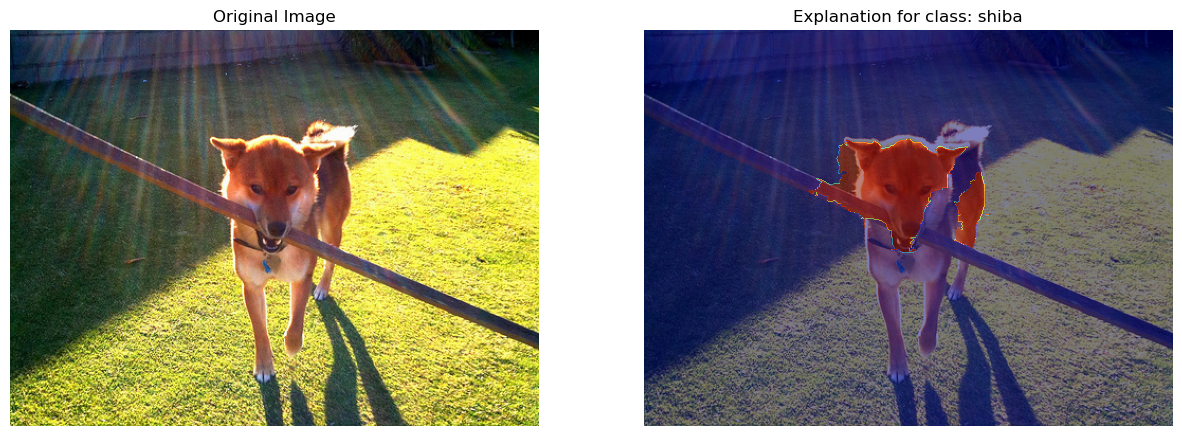

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
from PIL import Image
import os
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Checkpoint loaded successfully.")

def initialize_model(num_classes):
    model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, optimizer

def predict_image(images, model):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if not isinstance(images, list):
        images = [images]  


    images = [transform(img).unsqueeze(0) for img in images]
    images = torch.cat(images, dim=0)  # Create a batch
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.cpu().numpy()

def predict_image(images, model, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if not isinstance(images, list):
        images = [images] 

    images = [transform(img).unsqueeze(0) for img in images]
    images = torch.cat(images, dim=0)
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted_indices = torch.max(outputs, 1)
        predicted_labels = [class_names[idx] for idx in predicted_indices]

    return predicted_labels



def get_class_names(data_dir):
    """
    Extracts sorted class names from a directory that contains one subdirectory per class.
    """
    class_names = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]
    return class_names
    

num_classes = 35  
model, optimizer = initialize_model(num_classes)

data_dir='./data/pets/formatted_images'
load_checkpoint('Shuffle_net_model_checkpoint.pth', model, optimizer)
class_names = get_class_names(data_dir)

prediction = predict_image(image, model,class_names)
print('Predicted Class:', prediction)




def lime_explanation(model, image, class_names, num_samples=1000, num_features=5, top_labels=5):
    explainer = lime_image.LimeImageExplainer()

    def batch_predict(images):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        images = torch.stack([transform(Image.fromarray(img.astype('uint8'))) for img in images])
        images = images.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(images)
        return preds.cpu().numpy()
    
    explanation = explainer.explain_instance(np.array(image),
                                             classifier_fn=batch_predict,
                                             top_labels=top_labels,
                                             hide_color=0,
                                             num_samples=num_samples,
                                             num_features=num_features)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=False)
    

    fig, ax = plt.subplots(1, 2, figsize=(15, 8)) 
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')


    ax[1].imshow(image)
    ax[1].imshow(mask, cmap='jet', alpha=0.5) 
    ax[1].set_title(f'Explanation for class: {class_names[explanation.top_labels[0]]}')
    ax[1].axis('off')

    plt.show()

lime_explanation(model, image, class_names)


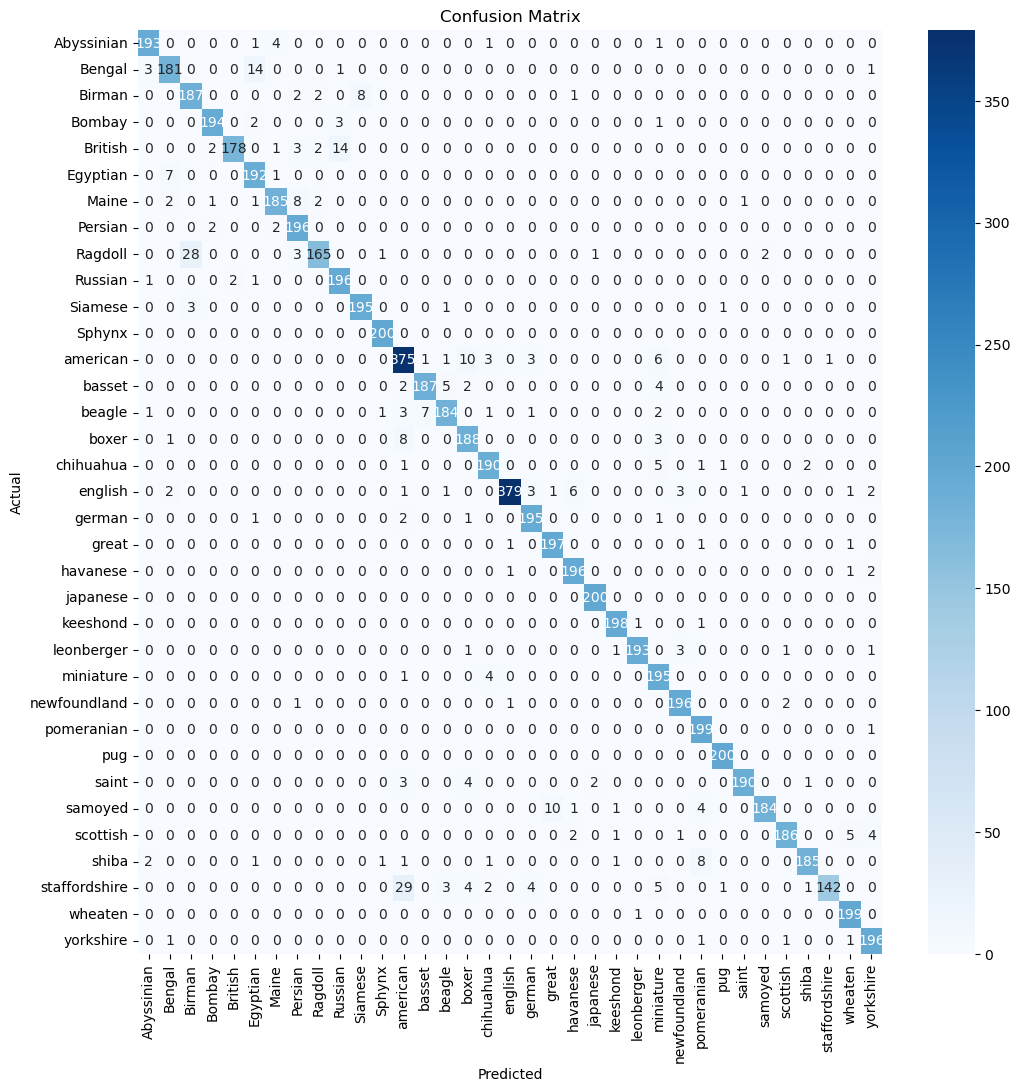

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os



transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def get_all_preds_labels(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    return all_preds.numpy(), all_labels.numpy()

predictions, labels = get_all_preds_labels(model, test_loader)

cm = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Aqui se ve como los errores en su gran mayoria se causan por razas muy similares, o incluso por la luz dentro de la imagen,
se podra apreciar en la seccion de abajo, ocurren muy pocos errores de cambio de especie, con casi todos los errores siendo
entendibles incluso desde una perspectiva humana, como vistos aqui abajo

Enter the nth incorrect prediction to display:  1


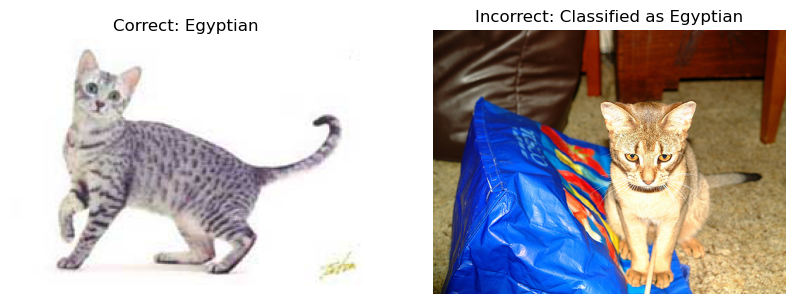

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)  


nth_incorrect = int(input("Enter the nth incorrect prediction to display: "))


incorrect_count = 0
incorrect_image_path = None
correct_image_path = None
predicted_label_incorrect = None
correct_label = None

for (images, labels), paths in zip(loader, dataset.imgs):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    if preds != labels:
        incorrect_count += 1
        if incorrect_count == nth_incorrect:
            incorrect_image_path = paths[0]
            predicted_label_incorrect = preds.item()
            # Now find a correct image of the same class
            for (corr_images, corr_labels), corr_paths in zip(loader, dataset.imgs):
                corr_images, corr_labels = corr_images.to(device), corr_labels.to(device)
                corr_outputs = model(corr_images)
                _, corr_preds = torch.max(corr_outputs, 1)
                if corr_preds == corr_labels == predicted_label_incorrect:
                    correct_image_path = corr_paths[0]
                    correct_label = corr_labels.item()
                    break
            if correct_image_path:
                break

if not correct_image_path:
    print("No correct example found for the given class or nth incorrect too large.")


if incorrect_image_path and correct_image_path:
    incorrect_image = Image.open(incorrect_image_path)
    correct_image = Image.open(correct_image_path)

    # Display the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(correct_image)
    axs[0].set_title(f'Correct: {dataset.classes[correct_label]}')
    axs[0].axis('off')

    axs[1].imshow(incorrect_image)
    axs[1].set_title(f'Incorrect: Classified as {dataset.classes[predicted_label_incorrect]}')
    axs[1].axis('off')

    plt.show()
else:
    print("Correct or incorrect image not found. Check the specified index.")

Aqui se puede ir cambiando de imagen en imagen cambiando el numero, siendo este el numero de imagen incorrecta dentro del confusion
matrix que se vera